<h1 style="text-align: center; font-weight: bold; font-size: 36px; background-color: #eaf8e6; padding: 15px; border-radius: 8px;">Flight Status Project</h1>

<h2>ETL Process Summary</h2>

<h3>1. Extract</h3>
<ul>
    <li>Connects to <strong>Google BigQuery</strong> for authentication.</li>
    <li>Reads multiple <strong>Parquet files</strong> containing flight data.</li>
</ul>
<h3>2. Transform</h3>
<ul>
    <li>Selects <strong>relevant columns</strong> for analysis.</li>
    <li>Handles <strong>null values</strong> for data consistency.</li>
    <li>Identifies and <strong>removes outliers</strong> using the <strong>IQR method</strong>.</li>
</ul>
<h3>3. Load</h3>
<ul>
    <li>Uploads the <strong>cleaned DataFrame</strong> to <strong>BigQuery</strong> for further analysis.</li>
</ul>
<p>This ensures <strong>clean, structured, and optimized</strong> flight data for insights and reporting. </p>


In [56]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

<h2 style="background-color: #eaf8e6; padding: 10px; border-radius: 5px;">Extract</h2>


In [59]:
# Authenticat Python script with Google BigQuery and connected to project bamboo-medium-450316-m8.

# Set project ID explicitly
project_id = "bamboo-medium-450316-m8"

client = bigquery.Client(project=project_id)

# Verify authentication
print("Authenticated with project:", client.project)


Authenticated with project: bamboo-medium-450316-m8


In [61]:
# Search for Parquet files in the current directory
parquet_files = glob("*.parquet")

print("Found Parquet files:", parquet_files)


Found Parquet files: ['Combined_Flights_2019.parquet', 'Combined_Flights_2020.parquet', 'Combined_Flights_2021.parquet']


<h2 style="background-color: #eaf8e6; padding: 10px; border-radius: 5px;">Transform</h2>

In [100]:
# Define the required columns
column_subset = [
    "FlightDate",
    "Airline",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName",
    "TaxiOut",
    "TaxiIn",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
    "AirTime",  
    "CRSElapsedTime",  
    "ActualElapsedTime", 
    "Distance", 
    "DayOfWeek", 
    "DepDel15", 
    "ArrDel15", 
    "DepartureDelayGroups", 
    "ArrivalDelayGroups"  
]
# Read and concatenate all Parquet files
dfs = [pd.read_parquet(f, columns=column_subset) for f in parquet_files]
df = pd.concat(dfs).reset_index(drop=True)

print("Final Data Shape:", df.shape)


Final Data Shape: (19425952, 30)


In [105]:
print(df.columns)

Index(['FlightDate', 'Airline', 'Flight_Number_Marketing_Airline', 'Origin',
       'Dest', 'Cancelled', 'Diverted', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'OriginAirportID', 'OriginCityName',
       'OriginStateName', 'DestAirportID', 'DestCityName', 'DestStateName',
       'TaxiOut', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelayMinutes',
       'AirTime', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance',
       'DayOfWeek', 'DepDel15', 'ArrDel15', 'DepartureDelayGroups',
       'ArrivalDelayGroups'],
      dtype='object')


<h2>Outlier Analysis from Boxplots</h2>

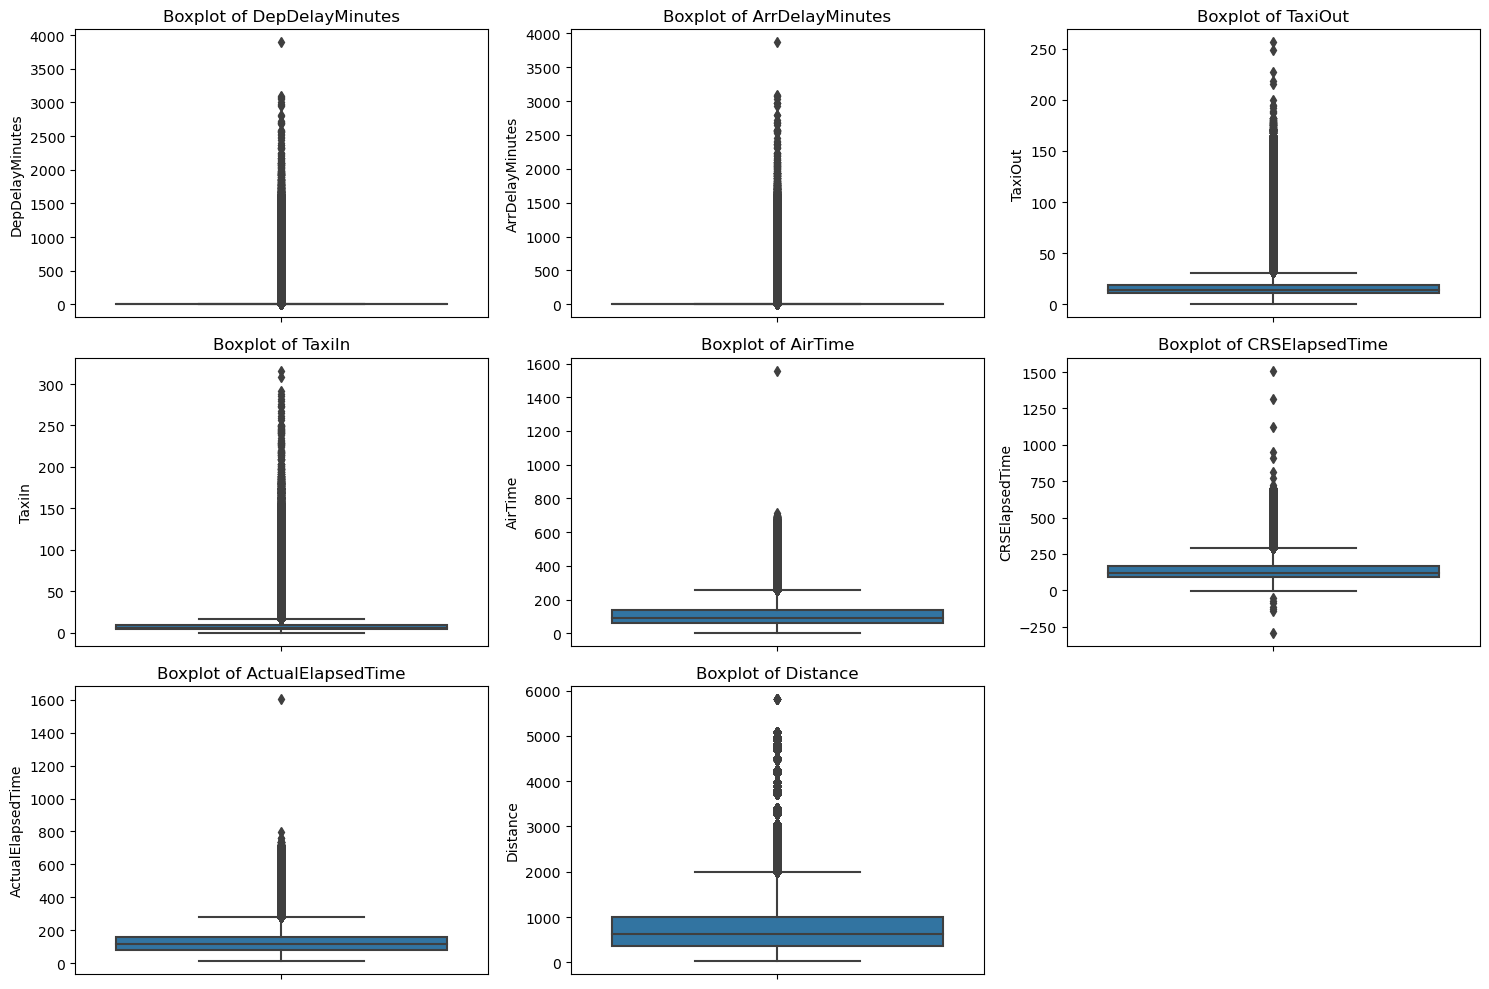

In [70]:
# Select numerical columns for outlier detection
num_columns = ["DepDelayMinutes", "ArrDelayMinutes", "TaxiOut", "TaxiIn", "AirTime", "CRSElapsedTime", "ActualElapsedTime", "Distance"]

# Create a boxplot for each numerical column to visualize outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


<h3>1. DepDelayMinutes (Departure Delay Minutes)</h3>
<ul>
    <li>Many outliers above <strong>500 minutes</strong>, some exceeding <strong>3000-4000 minutes</strong>.</li>
    <li>Could be <strong>data errors</strong> or rare <strong>severe delays</strong> (e.g., weather issues).</li>
</ul>

<h3>2. Distance</h3>
<ul>
    <li>Most flights have a normal distance range, but some exceed <strong>5000 miles</strong>.</li>
    <li>Likely represents <strong>long-haul flights</strong>, which may need separate analysis.</li>
</ul>


## Remove Outliers Using IQR Method 

In [73]:
# Define a function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter dataset
    df_filtered = df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]
    return df_filtered

# Select numerical columns to check for outliers
num_columns = ["DepDelayMinutes", "ArrDelayMinutes", "TaxiOut", "TaxiIn", "AirTime", "CRSElapsedTime", "ActualElapsedTime", "Distance"]

# Remove outliers
df_no_outliers = remove_outliers_iqr(df, num_columns)

print("Outliers removed successfully.")


Outliers removed successfully.


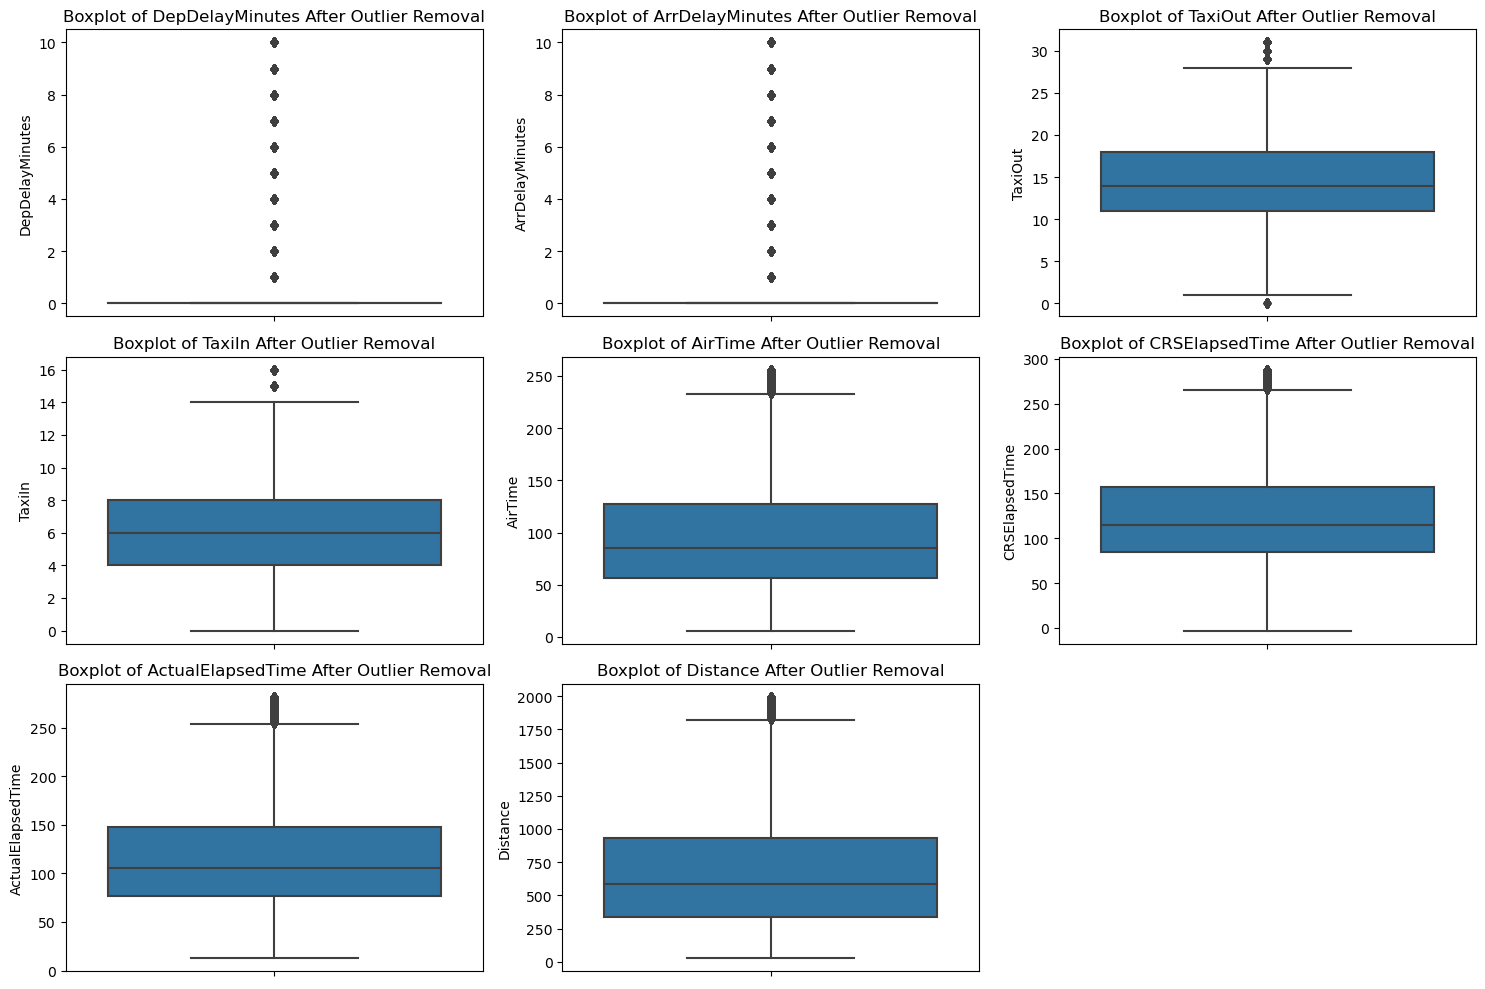

In [25]:
# Replot to analysis if outliers are removed

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df_no_outliers[col])
    plt.title(f'Boxplot of {col} After Outlier Removal')

plt.tight_layout()
plt.show()


<h2>Successful Outlier Reduction</h2>

<ul>
    <li>In the original boxplots, extreme values (e.g., <strong>DepDelayMinutes</strong> exceeding <strong>3000-4000 minutes</strong>) were clearly visible.</li>
    <li>Now, the highest delay values have been significantly reduced, with most delays within a <strong>reasonable range</strong>.</li>
</ul>


## Handling Null Values

In [21]:
df.isnull()

,FlightDate,Airline,Flight_Number_Marketing_Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,...,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,DayOfWeek,DepDel15,ArrDel15,DepartureDelayGroups,ArrivalDelayGroups
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19425947,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19425948,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19425949,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19425950,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
df.isnull().sum()

FlightDate                              0
Airline                                 0
Flight_Number_Marketing_Airline         0
Origin                                  0
Dest                                    0
Cancelled                               0
Diverted                                0
CRSDepTime                              0
DepTime                            555839
DepDelayMinutes                    556014
OriginAirportID                         0
OriginCityName                          0
OriginStateName                         0
DestAirportID                           0
DestCityName                            0
DestStateName                           0
TaxiOut                            563201
TaxiIn                             571342
CRSArrTime                              0
ArrTime                            571323
ArrDelayMinutes                    609888
AirTime                            609888
CRSElapsedTime                         16
ActualElapsedTime                 

In [26]:
df_cleaned = df.dropna()

In [32]:
df_cleaned.shape

(18816063, 30)

<h2>Null Values Removed for Data Consistency</h2>

<ul>
    <li>Null values have been removed to ensure <strong>consistent and accurate data insights</strong>.</li>
    <li>This enhances the <strong>reliability of analysis</strong> and prevents biases caused by missing data.</li>
    <li> Total records are close to 19 millions. </li>
</ul>


<h2 style="background-color: #eaf8e6; padding: 10px; border-radius: 5px;">Load</h2>

#### Uploading DataFrame to BigQuery




In [38]:
# Upload the DataFrame to BigQuery

# Define dataset and table (use the dataset you just created)
dataset_id = "flight_data"
table_id = "flights_3years"

# Initialize BigQuery client
client = bigquery.Client(project=project_id)

# Define full table path
table_ref = f"{project_id}.{dataset_id}.{table_id}"

# Upload DataFrame to BigQuery (automatically creates table if it doesn't exist)
job = client.load_table_from_dataframe(df_cleaned, table_ref)

# Wait for the job to complete
job.result()

print(f"Data uploaded successfully to BigQuery: {table_ref}")


Data uploaded successfully to BigQuery: bamboo-medium-450316-m8.flight_data.flights_3years


<ul>
    <li>Initializes BigQuery client and defines dataset/table.</li>
    <li>Uploads DataFrame, creating table if needed.</li>
    <li>Waits for completion and confirms success.</li>
</ul>